<a href="https://colab.research.google.com/github/Rodzxc/CPM-PERT/blob/main/CPM_Gantt_PERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="magenta">*1. Librerías*</font>

In [1]:
!pip install plotly
!pip install criticalpath
!pip install pertdist

  Preparing metadata (setup.py) ... done
  Created wheel for criticalpath: filename=criticalpath-0.1.5-py3-none-any.whl size=12027 sha256=04b22c41cde36c86519115612b02e1e8a93e3a2dcc2a8c722df167b9dd2a1e92
  Stored in directory: /root/.cache/pip/wheels/cd/48/07/ead88c1969e7d36a113558364b0e8fc7590f2d7c85481a6dde
Successfully built criticalpath


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

import random
import statistics as stat
from scipy.stats import triang
from pert import PERT
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from criticalpath import Node

import plotly.graph_objects as go
import plotly.express as px

from datetime import datetime, timedelta



# <font color="magenta">*2. Repertorio de Funciones*</font>

In [3]:
# Duración promedio del proyecto
def average(mydata):
    '''
    Calcula el promedio mediante la fórmula pert = (optimista + 4* más probable + pesimista) / 6
    Retorna una columna con los promedios de cada tarea.
    '''
    mydata['AVERAGE'] =  (mydata['OPTIMIST'] + 4*mydata['MOSTLIKELY'] + mydata['PESSIMIST']) / 6
    return mydata

In [4]:
# Calcular el Comienzo temprano (ES) y el Final temprano(EF)

# Manejo de errores en columna PREDECESSORS --> ID
def getTaskID(mydata, code):
    '''
    Verifica el ID en la columna PREDECESSORS.
    Si el ID es válido retorna el número de índice de ID,
    de lo contrario, retorna un mensaje de error.
    '''
    x = 0
    flag = 0
    for i in mydata['ID']:
        if(i == code):
            flag = 1
            break

        x+=1

    if(flag == 1):
        return x
    else:
        "errorIDMsg()"

# Cálculo de ES y EF
def forwardPass(mydata):
    '''
    Calcula los valores de ES y EF de cada tarea.
    Si PREDECESSORS es válido ES Y EF,
    de lo contrario, retorna un mensaje de error.
    '''

    ntask = mydata.shape[0] # Cantidad de filas (o tareas)
    ES = np.zeros(ntask, dtype = np.float64)
    EF = np.zeros(ntask, dtype = np.float64)
    temp = [] # contenedor temporal

    for i in range(ntask):
        if(mydata['PREDECESSORS'][i] == None):
            ES[i] = 0
            try:
                EF[i] = ES[i] + mydata['AVERAGE'][i]
            except:
                "errorAverageMsg()"

        else:
            for j in mydata['PREDECESSORS'][i]:
                index = getTaskID(mydata,j)

                if(index == i):
                    "errorPredMsg()"
                else:
                    temp.append(EF[index])

            ES[i] = max(temp)
            try:
                EF[i] = ES[i] + mydata['AVERAGE'][i]
            except:
                "errorAverageEMsg()"

        #reset temp
        temp = []


    #Actualizar el DataFrame:
    mydata['ES'] = ES
    mydata['EF'] = EF

    return mydata

In [5]:
# Calcular el Comienzo tardio (LS) y el Final tardio(LF)

# Cálculo de LS y LF
def backwardPass(mydata):
    '''
    Calcula los valores de LS y LF de cada tarea.
    Utiliza una columna auxiliar llamada PREDECESSORS para dichos cálculos
    pero no se incorpora en el retorno.
    '''
    ntask = mydata.shape[0] # Cantidad de filas (o tareas)
    temp = [] # Contenedor temporal
    LS = np.zeros(ntask, dtype = np.float64)
    LF = np.zeros(ntask, dtype = np.float64)
    SUCCESSORS = np.empty(ntask, dtype = object)

    # Crear columna temporal PREDECESSORS:
    for i in range(ntask-1, -1,-1):
        if(mydata['PREDECESSORS'][i] != None):
            for j in mydata['PREDECESSORS'][i]:
                index = getTaskID(mydata,j)
                if(SUCCESSORS[index] != None):
                    SUCCESSORS[index] += mydata['ID'][i]
                else:
                    SUCCESSORS[index] = mydata['ID'][i]


    for i in range(ntask-1, -1, -1):
        if(SUCCESSORS[i] == None):
            LF[i] = np.max(mydata['EF'])
            LS[i] = LF[i] - mydata['AVERAGE'][i]
        else:
            for j in SUCCESSORS[i]:
                index = getTaskID(mydata,j)
                temp.append(LS[index])

            LF[i] = min(temp)
            LS[i] = LF[i] - mydata['AVERAGE'][i]

            #reset temp
            temp = []


    #Actualizar el DataFrame
    mydata['LS'] = LS
    mydata['LF'] = LF

    return mydata


In [6]:
# Calcular la holgura (SLACK) y Criticidad de cada tarea
def slack(mydata):
    '''
    Retorna la columna SLACK con la holgura de cada tarea,
    Retorna la columna CRITICAL, si la tarea es critica el valor es "YES" , de lo contrario "NO".
    '''
    ntask = mydata.shape[0] # Cantidad de filas (o tareas)

    SLACK = np.zeros(shape = ntask, dtype = np.float16)
    CRITICAL = np.empty(shape = ntask,dtype = object)

    for i in range(ntask):
        SLACK[i] = mydata['LS'][i] - mydata['ES'][i]
        if(SLACK[i] == 0):
            CRITICAL[i] = "YES"
        else:
            CRITICAL[i] = "NO"


    #Actualizar el DataFrame
    mydata['SLACK'] = SLACK
    mydata['CRITICAL'] = CRITICAL

    return mydata

In [7]:
def nodes_graph(mydata):

      '''
      Retorna el grafico de nodos el cual muestra las reaciones de tareas y el camino crítico del proyecto
      '''

      # Crear un grafo dirigido
      G = nx.DiGraph()

      # Agregar nodos "START" y "END"
      G.add_node("START", label="START")
      G.add_node("END", label="END")

      # Agregar nodos y aristas al grafo
      tasks = set(k for i,j in mydata.iterrows() if pd.notnull(j['PREDECESSORS']) for k in j['PREDECESSORS'] )


      for i in range(len(mydata['ID'])):
          G.add_node(mydata['ID'][i], label=mydata['ID'][i], ES=mydata['ES'][i], EF=mydata['EF'][i], LS=mydata['LS'][i], LF=mydata['LF'][i])
          if mydata['PREDECESSORS'][i] is not None:
              for j in mydata['PREDECESSORS'][i]:
                  G.add_edge(j, mydata['ID'][i])
          else:
              G.add_edge("START", mydata['ID'][i])

          if mydata['ID'][i] not in tasks:
              G.add_edge(mydata['ID'][i], "END")


      # Posición de los nodos
      pos = nx.spring_layout(G)


      color2 = []
      for i in G.nodes:
        if i in ('START','END'):
          color2.append('lightgrey')
        else:
          for n in range(len(mydata['ID'])):
            if i == mydata['ID'][n]:
              # Determina el color de la barra
              color2.append('red' if mydata['CRITICAL'][n] == 'YES' else 'lightblue')
            else:
              "Error node or ID"

      for i,j in G.edges:
        if i in list(mydata[(mydata['CRITICAL']=='YES')]['ID']) and j in list(mydata[(mydata['CRITICAL']=='YES')]['ID']):
          G.add_edge(i, j, color='red')
        else:
          G.add_edge(i, j, color='black')
        if i in list(mydata[(mydata['CRITICAL']=='YES')]['ID']) and j == 'END':
          G.add_edge(i, j, color='red')
        if i =='START' and j in list(mydata[(mydata['CRITICAL']=='YES')]['ID']):
          G.add_edge(i, j, color='red')

      # Obtener colores de las aristas
      edge_colors = nx.get_edge_attributes(G,'color').values()


      plt.figure(figsize=(15, 15))
      nx.draw(G, pos, with_labels=True, font_size=10, node_size=500, node_color=color2, edge_color=edge_colors, font_color='black', font_weight='bold', arrowsize=20)

      # Añadir etiquetas adicionales
      labels = nx.get_edge_attributes(G, 'label')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

      for node in G.nodes():
        if node in ('START', 'END'): pass
        else:
          node_attrs = G.nodes[node]
          node_label = f"ES: {node_attrs['ES']} | EF: {node_attrs['EF']}\nLS: {node_attrs['LS']} | LF: {node_attrs['LF']}"
          plt.text(pos[node][0], pos[node][1] + 0.05, s=node_label, horizontalalignment='center')

      # Mostrar el gráfico
      plt.show()

In [8]:
# Fecha del proyecto
def datetime_project(mydata,
                     period,  # Las tareas tienen valores de inicio y final pero son horas?, dias?, meses? años?.
                              # Esta variable responde esas preguntas. Periodos de tiempo tipo str: 'h', 'd', 'm' ó 'y'. Ej. horas = 'h'
                     date_init = None,  # Fecha de inicio del proyecto en dd/mm/yyy . Ej. '02/05/2022' (02 de Mayo, 2022)
                     time_init = '0:0',  # Hora de inicio del proyecto en hh:mm . Ej. '08:30'
                     time_on=True  # valores en formato dd/mm/yyyy hh:mm , si es False dd/mm/yyyy.
                     ):
    '''
    Retorna las columnas:
      DATETIME_ES con la fecha del inicio temprano de cada tarea,
      DATETIME_EF con la fecha del final temprano de cada tarea.
      DATETIME_LF con la fecha del final tardío de cada tarea.
    '''
    # Formato 'dd/mm/yyyy hh:mm'
    date_format0 = '%d/%m/%Y %H:%M'
    date_format1 = '%d/%m/%Y'

    if (date_init != None):

        if (time_init != None):
          datetime_init = date_init + ' ' + time_init
          try:
            date_object = datetime.strptime(datetime_init, date_format0)
          except:
              print("Error in date_init or time_init")

        else:
          try:
            date_object = datetime.strptime(date_init, date_format0)
          except:
            print("Error in date_init")

    else:
        print("Error in date_init")

    sum_datetime_start = []
    sum_datetime_end = []
    sum_datetime_end_last = []

    time_units = {'h': 'hours', 'd': 'days', 'm': 'months', 'y': 'years'}

    if period in time_units:
        time_unit = time_units[period]
        for index, row in mydata.iterrows():

            nt_start = date_object + timedelta(**{time_unit: row['ES']})
            formatted_time = nt_start.strftime(date_format0)
            sum_datetime_start.append(formatted_time)

            nt_end = date_object + timedelta(**{time_unit: row['EF']})
            formatted_time = nt_end.strftime(date_format0)
            sum_datetime_end.append(formatted_time)

            nt_end_last = date_object + timedelta(**{time_unit: row['LF']})
            formatted_time = nt_end_last.strftime(date_format0)
            sum_datetime_end_last.append(formatted_time)
    else:
        print('Error in period')

    #Actualizar el DataFrame
    if time_on:
      mydata['DATETIME_ES'] = sum_datetime_start
      mydata['DATETIME_EF'] = sum_datetime_end
      mydata['DATETIME_LF'] = sum_datetime_end_last

      return mydata

    #Actualizar el DataFrame
    else:
      sum_datetime_start = [datetime.strptime(i, date_format0).strftime(date_format1) for i in sum_datetime_start]
      mydata['DATETIME_ES'] = sum_datetime_start

      sum_datetime_end = [datetime.strptime(i, date_format0).strftime(date_format1) for i in sum_datetime_end]
      mydata['DATETIME_EF'] = sum_datetime_end

      sum_datetime_end_last = [datetime.strptime(i, date_format0).strftime(date_format1) for i in sum_datetime_end_last]
      mydata['DATETIME_LF'] = sum_datetime_end_last

      return mydata

In [9]:
# Diagrama de Gantt
def gantt_chart(mydata,
                progress_bar=True, # Retorna una barra con el progreso de la columna PROGRESS%
                slack_bar=True    # Retorna una barra de holgura en cada tarea, columna SLACK
                ):

    '''
    Retorna un diagrama de Gantt, el cual puede reflejar el progreso de cada tarea y su holgura
    '''

    # Convertir las columnas de fechas a tipo datetime pandas
    DATETIME_ES = pd.to_datetime(mydata['DATETIME_ES'], format='%d/%m/%Y %H:%M')
    DATETIME_EF = pd.to_datetime(mydata['DATETIME_EF'], format='%d/%m/%Y %H:%M')
    DATETIME_LF = pd.to_datetime(mydata['DATETIME_LF'], format='%d/%m/%Y %H:%M')

    # Crear el DataFrame con las etiquetas de criticidad "C"
    critical = ['C' if crit == 'YES' else None for crit in mydata['CRITICAL']]

    if progress_bar:
      text_info = [f'{crit} {complete}%' if crit is not None else f'{complete}%' for crit, complete in zip(critical, mydata['PROGRESS%'])]
    else:
      text_info = [f'{crit}' if crit is not None else '' for crit in critical]

    # 1er gráfico de Gantt
    factor_progress = mydata['PROGRESS%']/100
    New_DATETIME_EF = DATETIME_ES + (DATETIME_EF - DATETIME_ES) * factor_progress
    fig = px.timeline(mydata, x_start=DATETIME_ES, x_end=New_DATETIME_EF, y='ID', color='TEAM',
                      labels={'TEAM': 'Team'},
                      custom_data=['TASK', 'DATETIME_ES', 'DATETIME_LF', 'SLACK']
                      )

    # 2do gráfico de Gantt
    fig2 = px.timeline(mydata, x_start=DATETIME_ES, x_end=DATETIME_EF, y='ID', color='TEAM',
                      custom_data=['TASK', 'DATETIME_ES', 'DATETIME_LF', 'SLACK'],text=text_info
                      ).update_traces(marker = dict(opacity = 0.5),showlegend=False)


    # 3er gráfico de Gantt SLACK
    fig3 = px.timeline(mydata, x_start=DATETIME_EF, x_end=DATETIME_LF, y='ID',
                      custom_data=['TASK', 'DATETIME_ES', 'DATETIME_LF', 'SLACK']
                      #,pattern_shape_sequence=["\\"]
                      ).update_traces(marker_color = 'white', opacity = 0.7, width = 0.5, marker_line_color='rgb(8,48,107)')


    if progress_bar: fig = fig
    else: fig=fig2.update_traces(marker = dict(opacity = 1))

    # Título y nombre eje y
    fig.update_layout(title_text='Diagrama de Gantt',
                      yaxis_title='ID')

    if slack_bar:
      # Agrega los trazos del segundo gráfico
      for trace in fig3.data:
          fig.add_trace(trace)
    if progress_bar:
      # Agrega los trazos del segundo gráfico
      for trace in fig2.data:
          fig.add_trace(trace)


    # Configurar las etiquetas en hover
    fig.update_traces(hovertemplate='<br>'.join([
                                                'Task: %{customdata[0]}',
                                                  'Start: %{customdata[1]}',
                                                  'Finish: %{customdata[2]}',
                                                  'Slack: %{customdata[3]}'
                                                ]),

                      textposition="outside"
                      ).data[0]

    # Ordenar las categorías en el eje y
    ca = mydata['ID'].tolist()
    ca.reverse()
    fig.update_yaxes(categoryorder='array', categoryarray=ca)


    # Agregar cuadrícula en el eje x e y
    fig.update_layout(xaxis_showgrid=True, yaxis_showgrid=True, xaxis_gridcolor='white', yaxis_gridcolor='white', xaxis_tickangle=-45)

    # Mostrar el gráfico
    if progress_bar: fig.show()
    else: fig2.show()


In [10]:
# Duración del proyecto, mínima, moda y máxima
def duration_proyect(mydata,
                     iter_moda=6000 # Iteración de la simulación MonteCarlo
                     ):

    '''
    Retorna:
     El Tiempo mínimo de duración del proyecto (todas las tareas realizadas con el tiempo optimista).
     La moda del tiempo de duración del proyecto (todas las tareas realizadas con simulación MonteCarlo).
     El Tiempo máximo de duración del proyecto (todas las tareas realizadas con el tiempo pesimista).
    La lista de los Tiempos que dura el proyecto según la simulación MonteCarlo

    '''

    dur = [] # Lista de los Tiempos que dura el proyecto según la simulación MonteCarlo

    dep = [] # Lista de tareas y predecesoras. Ej. (predecesora, tarea)-->('A', 'B')
    for i in range(mydata.shape[0]):
            if(mydata['PREDECESSORS'][i] == None):
                pass

            else:
                for j in mydata['PREDECESSORS'][i]:
                    dep.append((mydata['ID'][i], j))

    for r in range(iter_moda):
        p = Node('proyecto')
        tasks = [] # Lista de tareas y duración. Ej. (ID, duration: num)-->('A', duration: 10)
        for i,row in mydata.iterrows():
              X = random.triangular(row['OPTIMIST'], row['MOSTLIKELY'], row['PESSIMIST'])
              tasks.append((row['ID'], {"duration": round(X, 2)}))

        # Cargar al proyecto las tareas y sus duraciones
        for t in tasks:
            p.add(Node(t[0], duration=t[1]["duration"]))

        # Cargar al proyecto las tareas y predecesoras
        for d in dep:
            p.link(d[0],d[1])

        # Actualizar el proyecto:
        p.update_all()

        dur.append(p.duration)

    # Calcular la moda
    moda=stat.mode(dur)

    # Calcular el tiempo mínimo y máximo
    def minmax_duration_proyect(arg):
        '''
        Utiliza como arg las columnas OPTIMIST Y PESSIMIST.
        Retorna:
        El Tiempo mínimo de duración del proyecto (todas las tareas realizadas con el tiempo optimista).
        El Tiempo máximo de duración del proyecto (todas las tareas realizadas con el tiempo pesimista).
        '''
        p = Node('proyecto')
        tasks = [] # Lista de tareas y duración

        # Carga la dupla  (ID, duration: num)
        for i,row in mydata.iterrows():
              X = row[arg]
              tasks.append((row['ID'], {"duration": round(X, 2)}))

        # Cargar al proyecto las tareas y sus duraciones
        for t in tasks:
                p.add(Node(t[0], duration=t[1]["duration"]))

        # Cargar al proyecto las tareas y predecesoras
        for d in dep:
                p.link(d[0],d[1])

        # Actualizar el proyecto:
        p.update_all()

        return p.duration

    # Tiempo mínimo
    min = minmax_duration_proyect('OPTIMIST')
    # Tiempo máximo
    max = minmax_duration_proyect('PESSIMIST')


    return min, moda, max, dur

In [11]:
# Distribución triangular
def dist_triangle(min, # Valor mínimo
                  moda, # Valor moda
                  max, # Valor máximo
                  D, # Probabilidad de que el proyecto dure más de D tiempo (D;máx).
                  show= True # Gráfica de la distribución
                  ):

    '''
    Grafica y Calcula las probabilidades de terminar el proyecto en un tiempo determinado (D;máx).
    Retorna:
    Mensaje (msg).
    El valor de la probabilidad de terminar el proyecto en más de D tiempo.
    gráfica de la distribución, con la sombra de las probabilidades.
    '''

    # Definir parámetros de la distribución triangular
    a = min    # Límite inferior
    b = max    # Límite superior
    c = (moda - a) / (b - a)  # Modo de la distribución triangular

    # Generar distribución triangular
    dist_triangular = triang(c, loc=a, scale=b-a)

    # Calcular la probabilidad de que sea mayor que D
    probabilidad_mas_de_D = 1- dist_triangular.cdf(D)

    # Mensaje
    msg = print(f'La probabilidad de que el proyecto dure más de {D}: {round(probabilidad_mas_de_D*100,2)}%')

    if show:

        # Generar valores para graficar
        x = np.linspace(min, max, 1000)
        pdf = dist_triangular.pdf(x)

        # Crear la figura
        fig = go.Figure()

        # Graficar
        fig.add_trace(go.Scatter(x=x, y=pdf, mode='lines')).update_traces(showlegend=False)

        # Rellenar área
        x2 = x[x >= D]
        pdf2 = pdf[len(x) - len(x2):]
        fig.add_trace(go.Scatter(x=x2, y=pdf2, mode='lines', fill='tozeroy', fillcolor='rgba(0,255,0,0.3)')).update_traces(showlegend=False)

        # Personalizar diseño
        fig.update_layout(title='Distribución Triangular - Probabilidad de la duración del proyecto',
                          xaxis_title='Duración',
                          yaxis_title='Densidad de Probabilidad',
                          legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
                          template='plotly_white',
                          hovermode=False)

        # Mostrar figura
        fig.show(config={'displayModeBar': False})

    return msg, round(probabilidad_mas_de_D,4)

In [12]:
def dist_pert(min, # Valor mínimo
              moda, # Valor moda
              max, # Valor máximo
              D, # Probabilidad de que el proyecto dure más de D tiempo (D;máx).
              show= True # Gráfica de la distribución
              ):

    '''
    Grafica y Calcula las probabilidades de terminar el proyecto en un tiempo determinado (D;máx).
    Retorna:
    Mensaje (msg).
    El valor de la probabilidad de terminar el proyecto en más de D tiempo.
    gráfica de la distribución, con la sombra de las probabilidades.
    '''

    # # Generar distribución Pert
    pert_distribution = PERT(min, moda, max)

    # Calcular la probabilidad (D;máx)
    probabilidad_mas_de_D= pert_distribution.sf(D)

    # Mensaje
    msg = print(f'La probabilidad de que el proyecto dure más de {D}: {round(probabilidad_mas_de_D*100,2)}%')

    if show:
        # Generar datos de la distribución
        x = np.linspace(min, max, 1000)
        pdf = pert_distribution.pdf(x)  # Probabilidad densidad función

        # Crear figura de Plotly
        fig = go.Figure()

        # Graficar
        fig.add_trace(go.Scatter(x=x, y=pdf, mode='lines', name='Distribución PERT', line=dict(color='royalblue')))


        # Rellenar área
        x2 = x[x >= D]
        pdf2 = pdf[len(x) - len(x2):]
        fig.add_trace(go.Scatter(x=x2, y=pdf2, mode='lines', fill='tozeroy', fillcolor='rgba(0,255,0,0.3)')).update_traces(showlegend=False)

        # Personalizar diseño
        fig.update_layout(title='Distribución Pert - Probabilidad de la duración del proyecto',
                                  xaxis_title='Duración',
                                  yaxis_title='Densidad de Probabilidad',
                                  legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
                                  template='plotly_white',
                                  hovermode=False)


        # Mostrar figura
        fig.show(config={'displayModeBar': False})

    return msg, round(probabilidad_mas_de_D,4)

# <font color="magenta">*3. Gestión de Proyecto - Análisis de tareas y tie![gantt1.PNG](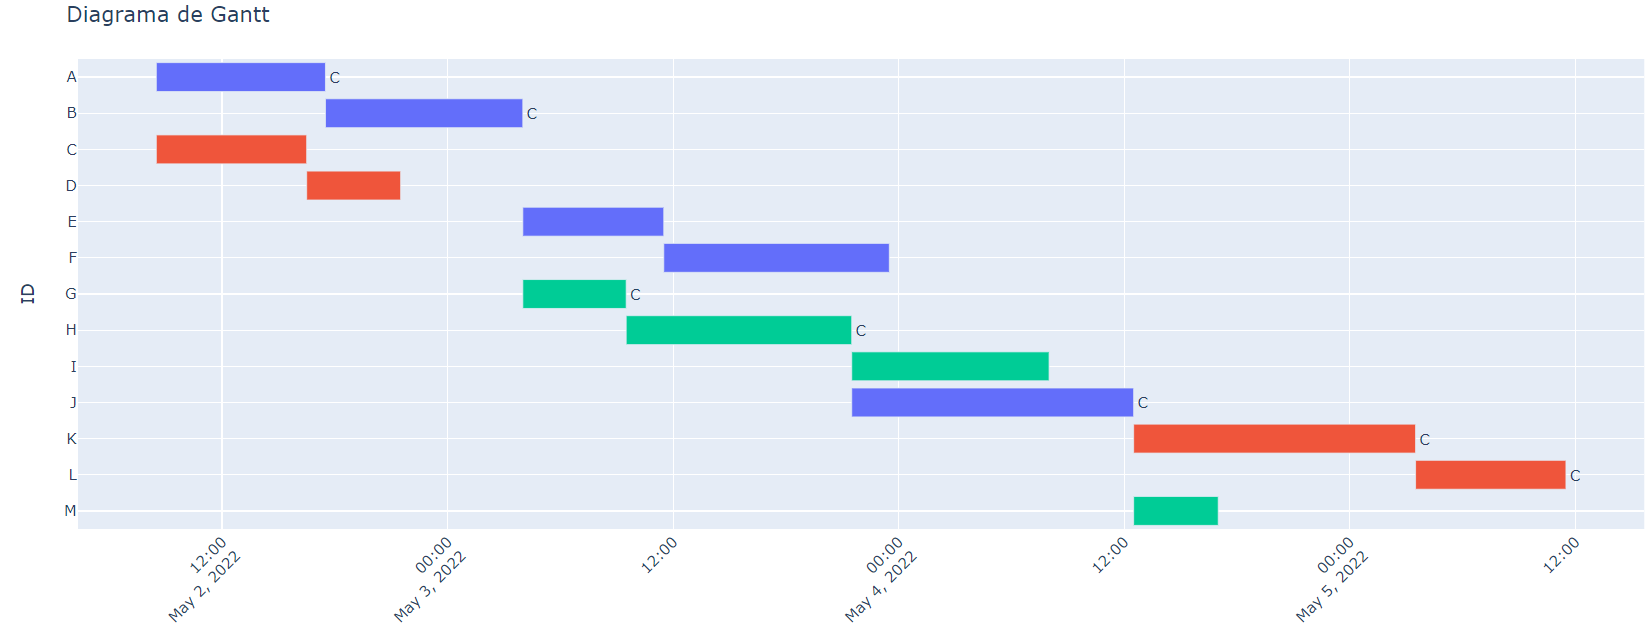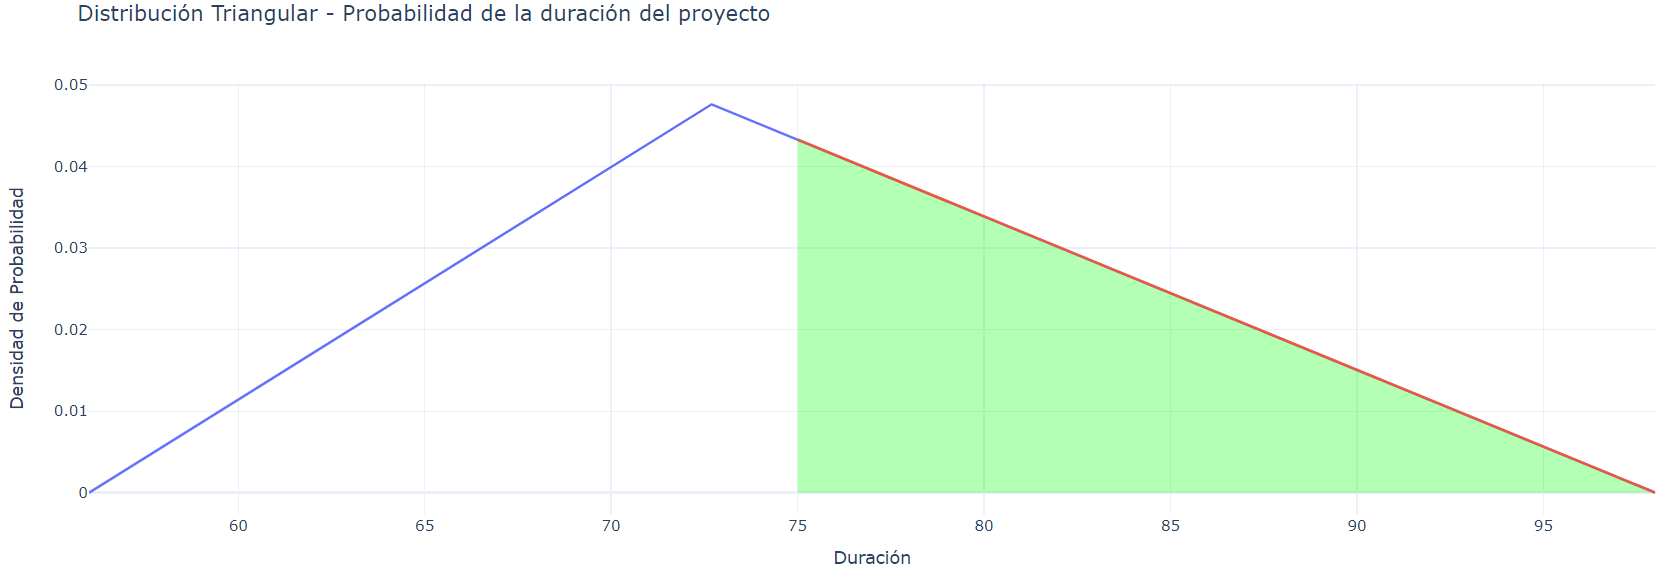)mpos*</font>

### 3.1. Confección de Dataframe
Se crea un Dataframe del Proyecto con los siguientes datos los siguientes datos:

- TEAM: Equipo o indviduo encargado de realizar la tarea.
- TASK: Descripción de la tarea a realizar.
- ID: Código de la tarea (tipo str).
- PREDECESSORS: Tarea/as predecesora/as (tipo str). Si no tiene es None.
- OPTIMIST: Tiempo optimista de la tarea.
- MOSTLIKELY: Tiempo más probable de la tarea.
- PESSIMIST: Tiempo pesimista de la tarea.

In [13]:
# col: columnas y values: valores de cada tarea
mydata= {
        'col':['TEAM', 'TASK', 'ID','PREDECESSORS','OPTIMIST', 'MOSTLIKELY','PESSIMIST'],

        'values':[
                    ['David', 'T1', 'A', None, 6, 9, 12],
                    ['David', 'T2', 'B', 'A', 8, 10, 15],
                    ['Lucas', 'T3', 'C', None, 7, 8, 9],
                    ['Lucas', 'T4', 'D', 'C', 4, 5, 6],
                    ['David', 'T5', 'E', ('B','D'), 7, 7, 10],
                    ['David', 'T6', 'F', 'E', 12, 12, 12],
                    ['Maria', 'T7', 'G', ('B','D'), 3, 6, 6],
                    ['Maria', 'T8', 'H', 'G', 8, 12, 16],
                    ['Maria', 'T9', 'I', 'H', 4, 10, 19],
                    ['David', 'T10', 'J', 'H', 14, 15, 16],
                    ['Lucas', 'T11', 'K', 'J', 10, 15, 20],
                    ['Lucas', 'T12', 'L', ('H','K'), 7, 7, 13],
                    ['Maria', 'T13', 'M', 'J', 4, 4, 7]
                ]
  }

In [14]:
# Crear DataFrame
df = pd.DataFrame(mydata['values'], columns=mydata['col'])
df

,TEAM,TASK,ID,PREDECESSORS,OPTIMIST,MOSTLIKELY,PESSIMIST
0,David,T1,A,None,6,9,12
1,David,T2,B,A,8,10,15
2,Lucas,T3,C,None,7,8,9
3,Lucas,T4,D,C,4,5,6
4,David,T5,E,"(B, D)",7,7,10
5,David,T6,F,E,12,12,12
6,Maria,T7,G,"(B, D)",3,6,6
7,Maria,T8,H,G,8,12,16
8,Maria,T9,I,H,4,10,19
9,David,T10,J,H,14,15,16


### 3.2. Cálculos del Tiempos, Criticidad, Fechas.  

In [15]:
# Promedio de tiempo
df = average(df)
df

,TEAM,TASK,ID,PREDECESSORS,OPTIMIST,MOSTLIKELY,PESSIMIST,AVERAGE
0,David,T1,A,None,6,9,12,9.0
1,David,T2,B,A,8,10,15,10.5
2,Lucas,T3,C,None,7,8,9,8.0
3,Lucas,T4,D,C,4,5,6,5.0
4,David,T5,E,"(B, D)",7,7,10,7.5
5,David,T6,F,E,12,12,12,12.0
6,Maria,T7,G,"(B, D)",3,6,6,5.5
7,Maria,T8,H,G,8,12,16,12.0
8,Maria,T9,I,H,4,10,19,10.5
9,David,T10,J,H,14,15,16,15.0


In [16]:
# Cálculo del Inicio temprano y el Final temprano
df = forwardPass(df)
df

,TEAM,TASK,ID,PREDECESSORS,OPTIMIST,MOSTLIKELY,PESSIMIST,AVERAGE,ES,EF
0,David,T1,A,None,6,9,12,9.0,0.0,9.0
1,David,T2,B,A,8,10,15,10.5,9.0,19.5
2,Lucas,T3,C,None,7,8,9,8.0,0.0,8.0
3,Lucas,T4,D,C,4,5,6,5.0,8.0,13.0
4,David,T5,E,"(B, D)",7,7,10,7.5,19.5,27.0
5,David,T6,F,E,12,12,12,12.0,27.0,39.0
6,Maria,T7,G,"(B, D)",3,6,6,5.5,19.5,25.0
7,Maria,T8,H,G,8,12,16,12.0,25.0,37.0
8,Maria,T9,I,H,4,10,19,10.5,37.0,47.5
9,David,T10,J,H,14,15,16,15.0,37.0,52.0


In [17]:
# Cálculo del Inicio tárdio y el Final tárdio
df = backwardPass(df)
df

,TEAM,TASK,ID,PREDECESSORS,OPTIMIST,MOSTLIKELY,PESSIMIST,AVERAGE,ES,EF,LS,LF
0,David,T1,A,None,6,9,12,9.0,0.0,9.0,0.0,9.0
1,David,T2,B,A,8,10,15,10.5,9.0,19.5,9.0,19.5
2,Lucas,T3,C,None,7,8,9,8.0,0.0,8.0,6.5,14.5
3,Lucas,T4,D,C,4,5,6,5.0,8.0,13.0,14.5,19.5
4,David,T5,E,"(B, D)",7,7,10,7.5,19.5,27.0,55.5,63.0
5,David,T6,F,E,12,12,12,12.0,27.0,39.0,63.0,75.0
6,Maria,T7,G,"(B, D)",3,6,6,5.5,19.5,25.0,19.5,25.0
7,Maria,T8,H,G,8,12,16,12.0,25.0,37.0,25.0,37.0
8,Maria,T9,I,H,4,10,19,10.5,37.0,47.5,64.5,75.0
9,David,T10,J,H,14,15,16,15.0,37.0,52.0,37.0,52.0


In [18]:
# Cálculo de la holgura y criticidad
df = slack(df)
df

,TEAM,TASK,ID,PREDECESSORS,OPTIMIST,MOSTLIKELY,PESSIMIST,AVERAGE,ES,EF,LS,LF,SLACK,CRITICAL
0,David,T1,A,None,6,9,12,9.0,0.0,9.0,0.0,9.0,0.0,YES
1,David,T2,B,A,8,10,15,10.5,9.0,19.5,9.0,19.5,0.0,YES
2,Lucas,T3,C,None,7,8,9,8.0,0.0,8.0,6.5,14.5,6.5,NO
3,Lucas,T4,D,C,4,5,6,5.0,8.0,13.0,14.5,19.5,6.5,NO
4,David,T5,E,"(B, D)",7,7,10,7.5,19.5,27.0,55.5,63.0,36.0,NO
5,David,T6,F,E,12,12,12,12.0,27.0,39.0,63.0,75.0,36.0,NO
6,Maria,T7,G,"(B, D)",3,6,6,5.5,19.5,25.0,19.5,25.0,0.0,YES
7,Maria,T8,H,G,8,12,16,12.0,25.0,37.0,25.0,37.0,0.0,YES
8,Maria,T9,I,H,4,10,19,10.5,37.0,47.5,64.5,75.0,27.5,NO
9,David,T10,J,H,14,15,16,15.0,37.0,52.0,37.0,52.0,0.0,YES


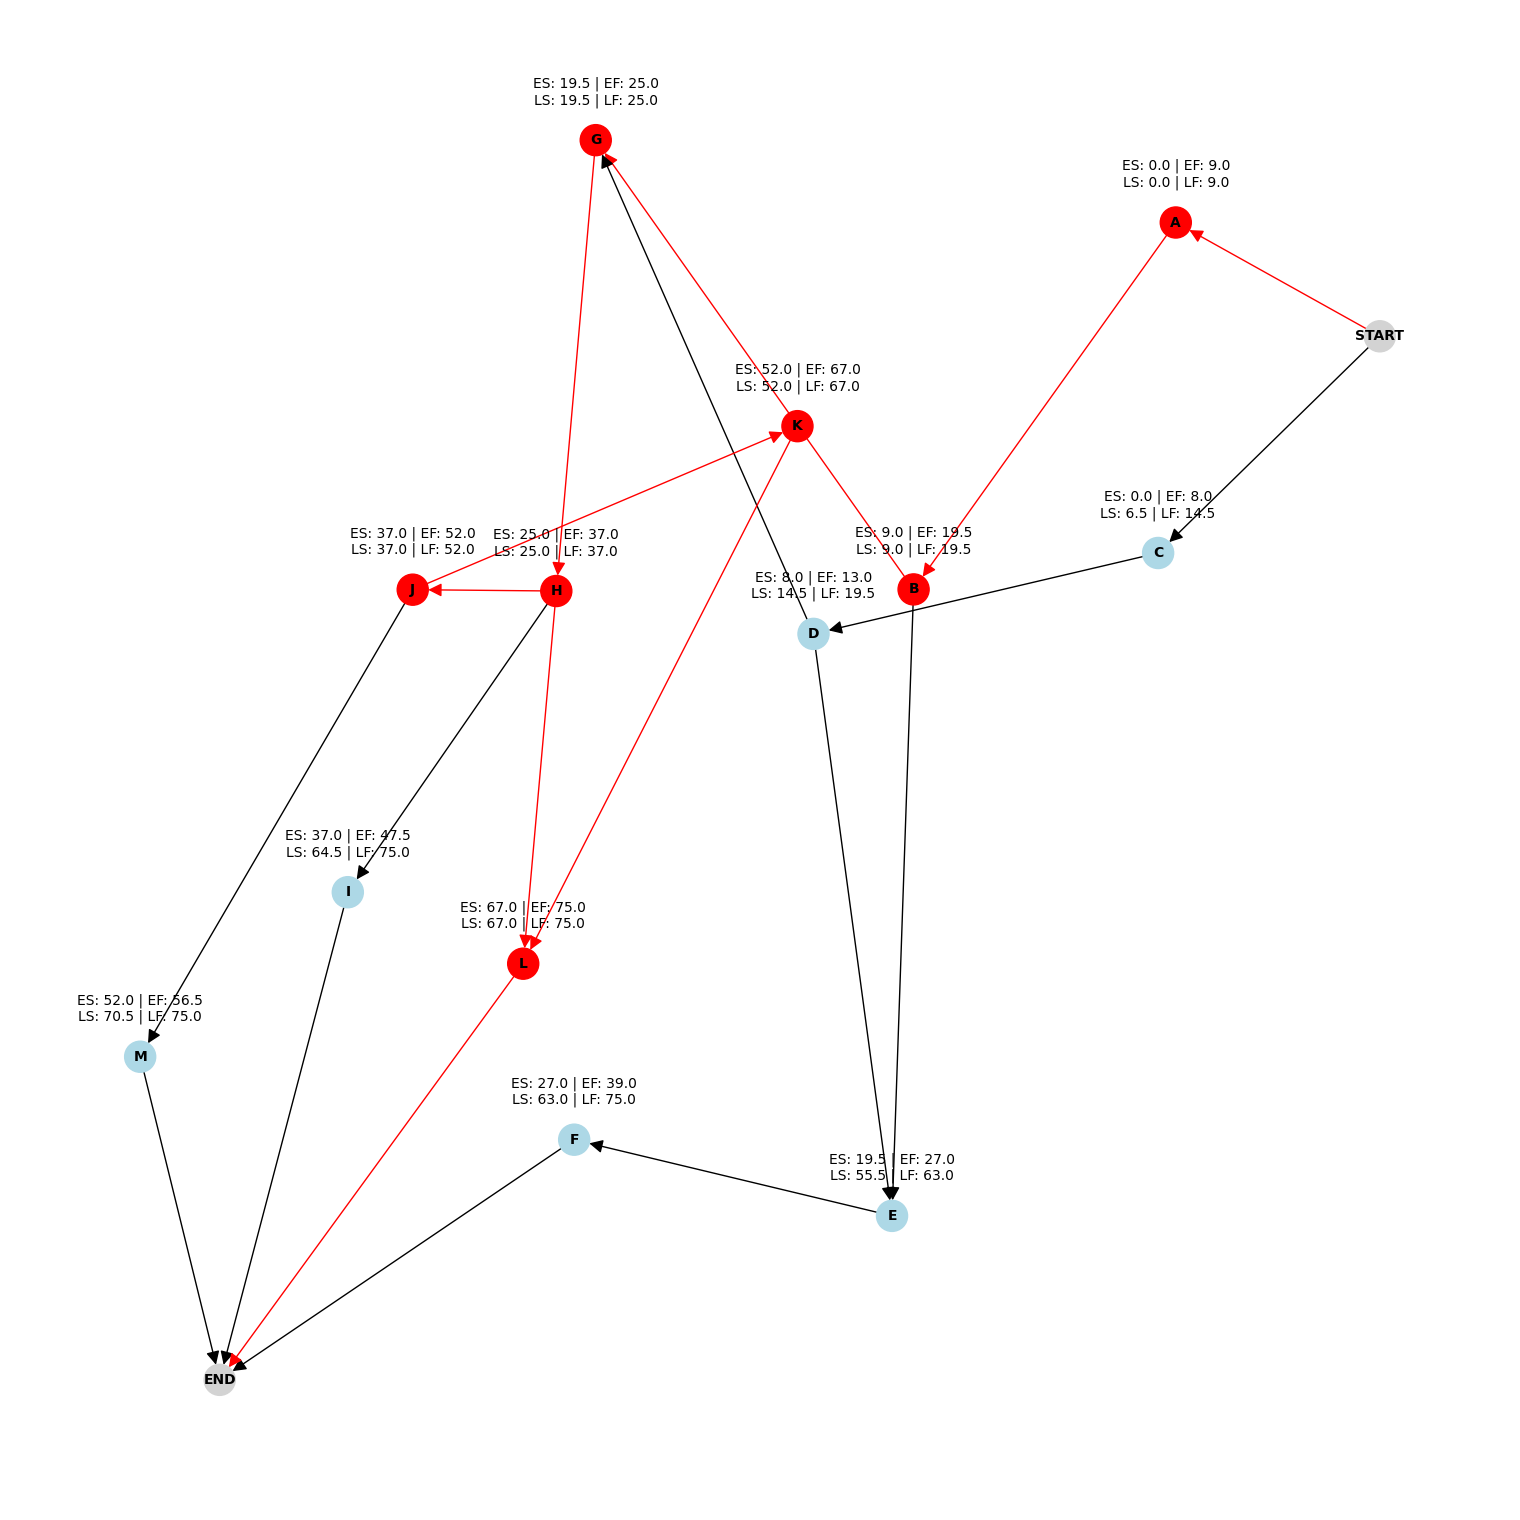

In [19]:
# Gráfica de nodos, camino crítico
nodes_graph(df)

In [20]:
# Cálculo de fechas, inicio temprano, final temprano y final tárdio.

# Como este proyecto tiene una duración en horas, es necesario especificar su hora de inicio.

date = '02/05/2022' # Fecha de inicio
time = '8:30' # Hora de inicio

df = datetime_project(df, 'h', # 'h' inidica el periodo en horas
                          date_init = date,
                          time_init=time)
df

,TEAM,TASK,ID,PREDECESSORS,OPTIMIST,MOSTLIKELY,PESSIMIST,AVERAGE,ES,EF,LS,LF,SLACK,CRITICAL,DATETIME_ES,DATETIME_EF,DATETIME_LF
0,David,T1,A,None,6,9,12,9.0,0.0,9.0,0.0,9.0,0.0,YES,02/05/2022 08:30,02/05/2022 17:30,02/05/2022 17:30
1,David,T2,B,A,8,10,15,10.5,9.0,19.5,9.0,19.5,0.0,YES,02/05/2022 17:30,03/05/2022 04:00,03/05/2022 04:00
2,Lucas,T3,C,None,7,8,9,8.0,0.0,8.0,6.5,14.5,6.5,NO,02/05/2022 08:30,02/05/2022 16:30,02/05/2022 23:00
3,Lucas,T4,D,C,4,5,6,5.0,8.0,13.0,14.5,19.5,6.5,NO,02/05/2022 16:30,02/05/2022 21:30,03/05/2022 04:00
4,David,T5,E,"(B, D)",7,7,10,7.5,19.5,27.0,55.5,63.0,36.0,NO,03/05/2022 04:00,03/05/2022 11:30,04/05/2022 23:30
5,David,T6,F,E,12,12,12,12.0,27.0,39.0,63.0,75.0,36.0,NO,03/05/2022 11:30,03/05/2022 23:30,05/05/2022 11:30
6,Maria,T7,G,"(B, D)",3,6,6,5.5,19.5,25.0,19.5,25.0,0.0,YES,03/05/2022 04:00,03/05/2022 09:30,03/05/2022 09:30
7,Maria,T8,H,G,8,12,16,12.0,25.0,37.0,25.0,37.0,0.0,YES,03/05/2022 09:30,03/05/2022 21:30,03/05/2022 21:30
8,Maria,T9,I,H,4,10,19,10.5,37.0,47.5,64.5,75.0,27.5,NO,03/05/2022 21:30,04/05/2022 08:00,05/05/2022 11:30
9,David,T10,J,H,14,15,16,15.0,37.0,52.0,37.0,52.0,0.0,YES,03/05/2022 21:30,04/05/2022 12:30,04/05/2022 12:30


### 3.3 Progeso de cada tarea.
Denota los avances en cada tarea en términos porcentuales.

In [21]:
progress= {
        'col':    [ 'TASK', 'ID','PROGRESS%'],
        'values':[
                    [ 'T1', 'A', 50],
                    [ 'T2', 'B', 95],
                    [ 'T3', 'C', 88],
                    [ 'T4', 'D', 76],
                    [ 'T5', 'E', 70],
                    [ 'T6', 'F', 69],
                    [ 'T7', 'G', 68],
                    [ 'T8', 'H', 50],
                    [ 'T9', 'I', 58],
                    [ 'T10', 'J', 48],
                    [ 'T11', 'K', 35],
                    [ 'T12', 'L', 35],
                    [ 'T13', 'M', 12]
                ]
  }

# Crear DataFrame
progress = pd.DataFrame(progress['values'], columns=progress['col'])
progress = pd.merge(progress, df[['ID', 'TEAM']], on='ID', how='left')
progress

,TASK,ID,PROGRESS%,TEAM
0,T1,A,50,David
1,T2,B,95,David
2,T3,C,88,Lucas
3,T4,D,76,Lucas
4,T5,E,70,David
5,T6,F,69,David
6,T7,G,68,Maria
7,T8,H,50,Maria
8,T9,I,58,Maria
9,T10,J,48,David


In [22]:
# Agrego el progreso al DataFrame del proyecto
df = pd.merge(df, progress[['ID', 'PROGRESS%']], on='ID', how='left')

In [23]:
df

,TEAM,TASK,ID,PREDECESSORS,OPTIMIST,MOSTLIKELY,PESSIMIST,AVERAGE,ES,EF,LS,LF,SLACK,CRITICAL,DATETIME_ES,DATETIME_EF,DATETIME_LF,PROGRESS%
0,David,T1,A,None,6,9,12,9.0,0.0,9.0,0.0,9.0,0.0,YES,02/05/2022 08:30,02/05/2022 17:30,02/05/2022 17:30,50
1,David,T2,B,A,8,10,15,10.5,9.0,19.5,9.0,19.5,0.0,YES,02/05/2022 17:30,03/05/2022 04:00,03/05/2022 04:00,95
2,Lucas,T3,C,None,7,8,9,8.0,0.0,8.0,6.5,14.5,6.5,NO,02/05/2022 08:30,02/05/2022 16:30,02/05/2022 23:00,88
3,Lucas,T4,D,C,4,5,6,5.0,8.0,13.0,14.5,19.5,6.5,NO,02/05/2022 16:30,02/05/2022 21:30,03/05/2022 04:00,76
4,David,T5,E,"(B, D)",7,7,10,7.5,19.5,27.0,55.5,63.0,36.0,NO,03/05/2022 04:00,03/05/2022 11:30,04/05/2022 23:30,70
5,David,T6,F,E,12,12,12,12.0,27.0,39.0,63.0,75.0,36.0,NO,03/05/2022 11:30,03/05/2022 23:30,05/05/2022 11:30,69
6,Maria,T7,G,"(B, D)",3,6,6,5.5,19.5,25.0,19.5,25.0,0.0,YES,03/05/2022 04:00,03/05/2022 09:30,03/05/2022 09:30,68
7,Maria,T8,H,G,8,12,16,12.0,25.0,37.0,25.0,37.0,0.0,YES,03/05/2022 09:30,03/05/2022 21:30,03/05/2022 21:30,50
8,Maria,T9,I,H,4,10,19,10.5,37.0,47.5,64.5,75.0,27.5,NO,03/05/2022 21:30,04/05/2022 08:00,05/05/2022 11:30,58
9,David,T10,J,H,14,15,16,15.0,37.0,52.0,37.0,52.0,0.0,YES,03/05/2022 21:30,04/05/2022 12:30,04/05/2022 12:30,48


### 3.4. Diagrama de Gantt

In [24]:
# Diagrama simple, C indica tarea critica
gantt_chart(df, progress_bar = False, slack_bar=False)

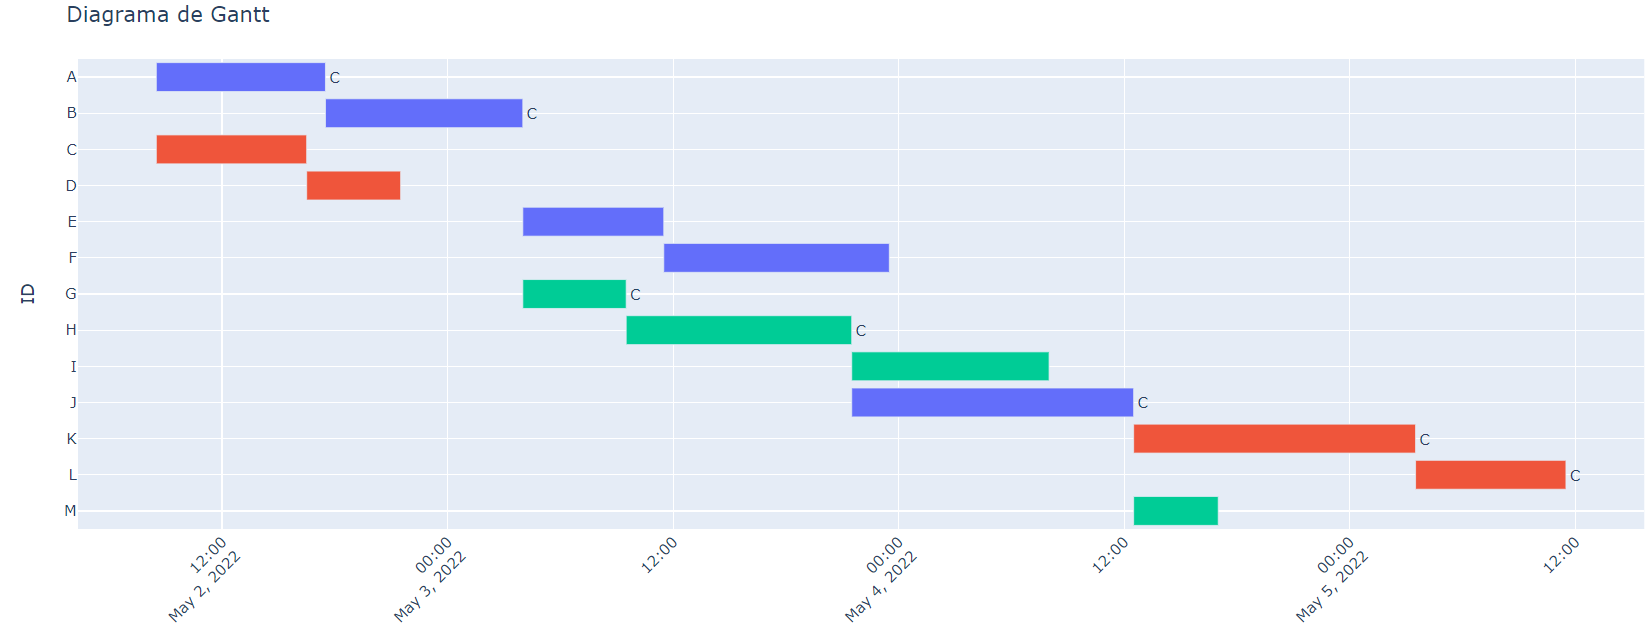

In [25]:
#Diagrama con el progeso de cada tarea
gantt_chart(df, progress_bar = True, slack_bar=False )

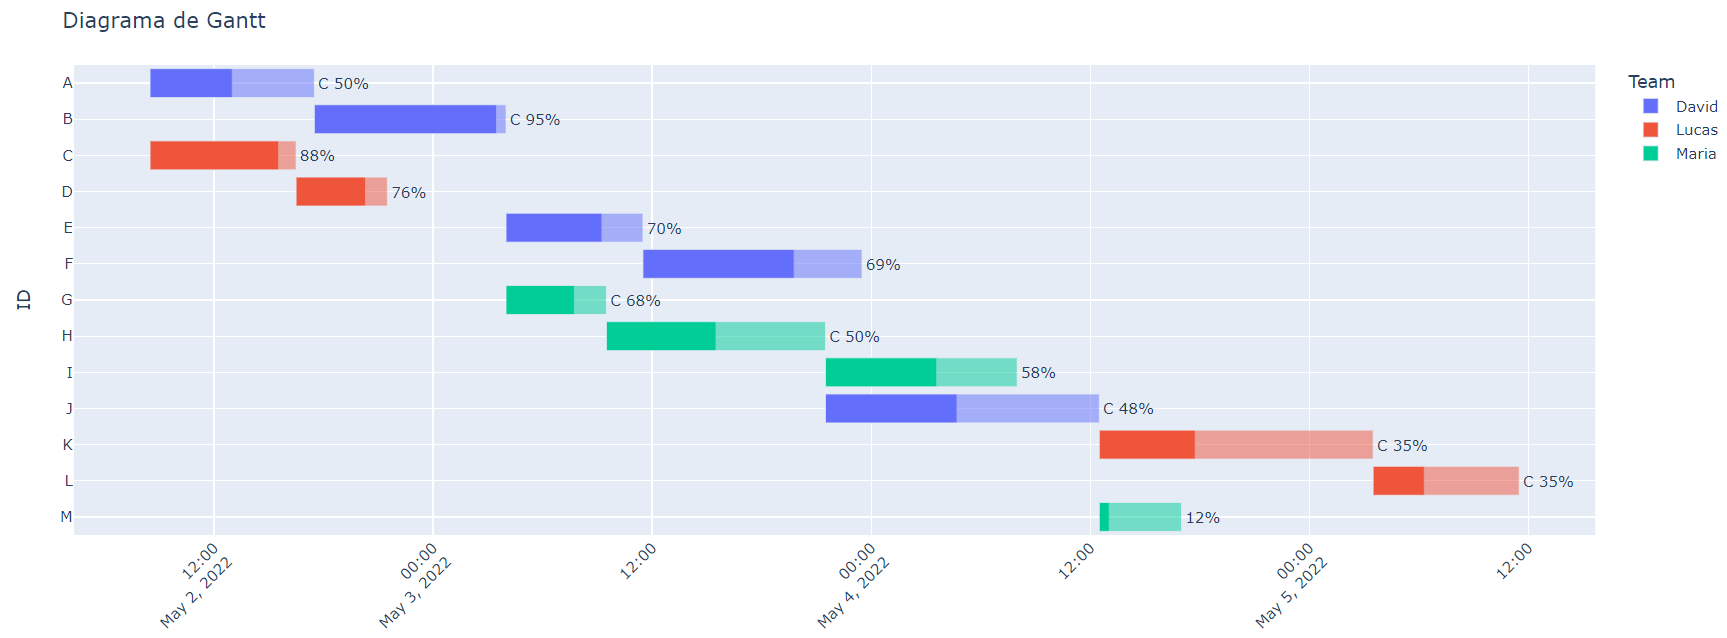

In [26]:
# Diagrama con el progreso y holgura
gantt_chart(df, progress_bar = True, slack_bar=True )

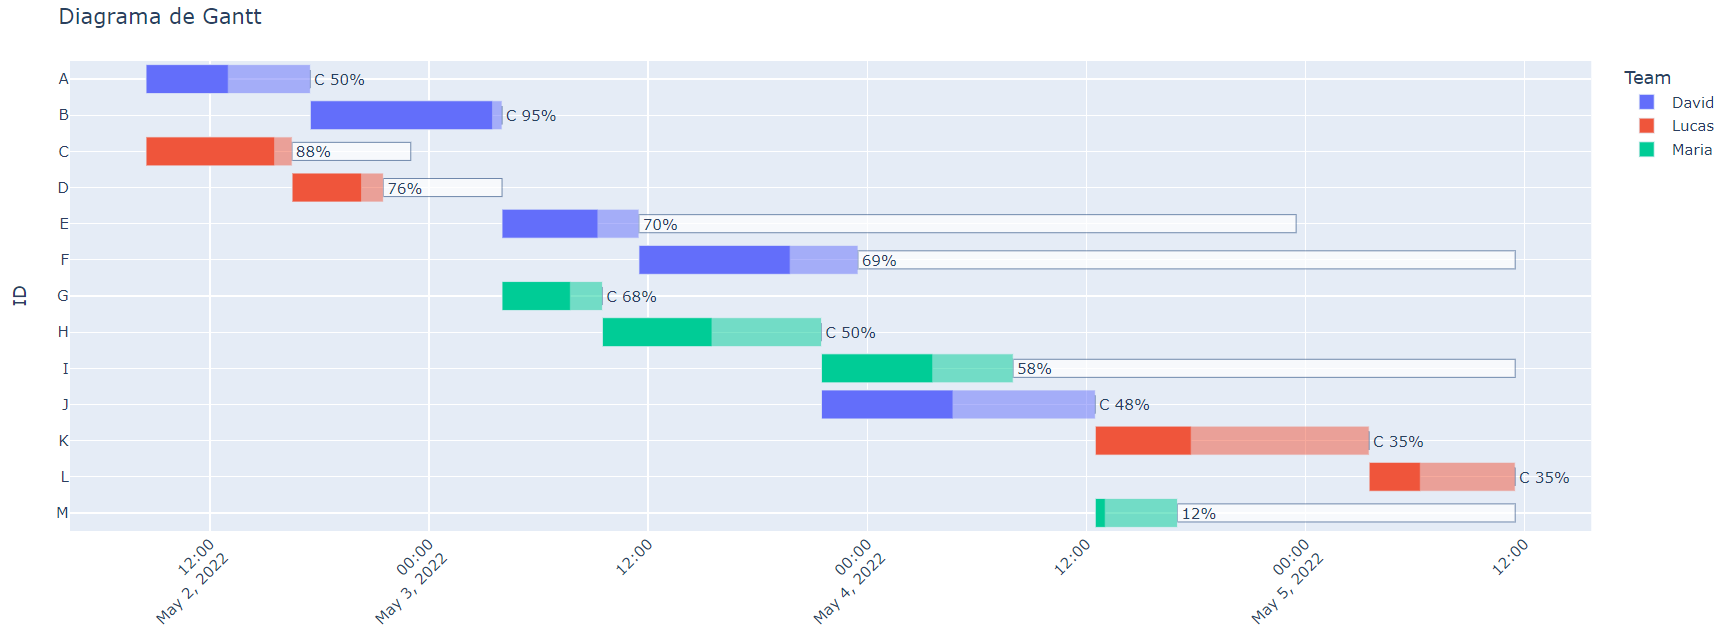

### 3.5. Duración del proyecto expresado en probabilidades.

In [27]:
# Duración mínima, moda y máxima del proyecto. También retorna una lista de duración del proyecto según la simulación MonteCarlo
min, moda, max, dur = duration_proyect(df)

In [28]:
print(f'Duración del Proyecto:')
print(f'min: {min}')
print(f'moda: {moda}')
print(f'max: {max}')

Duración del Proyecto:
min: 56
moda: 73.63
max: 98


In [29]:
# Probabilidad de durar más de 75 horas, Distribución Triangular
msg_t, _t = dist_triangle(min, moda, max, 75)
msg_t

La probabilidad de que el proyecto dure más de 75: 51.68%


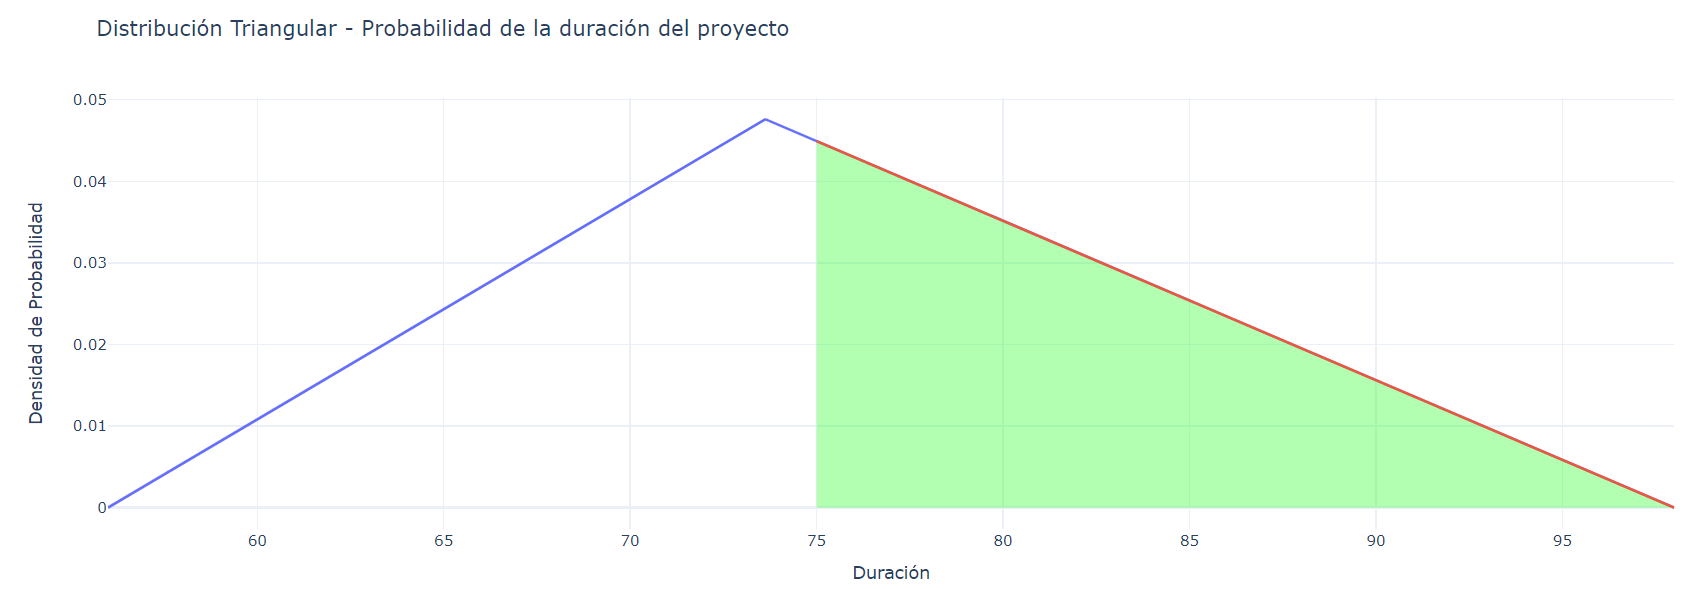

In [30]:
# Probabilidad de durar más de 75 horas, Distribución Pert
msg_p, _p = dist_pert(min, moda, max, 75, show= True)
msg_p


La probabilidad de que el proyecto dure más de 75: 47.7%


  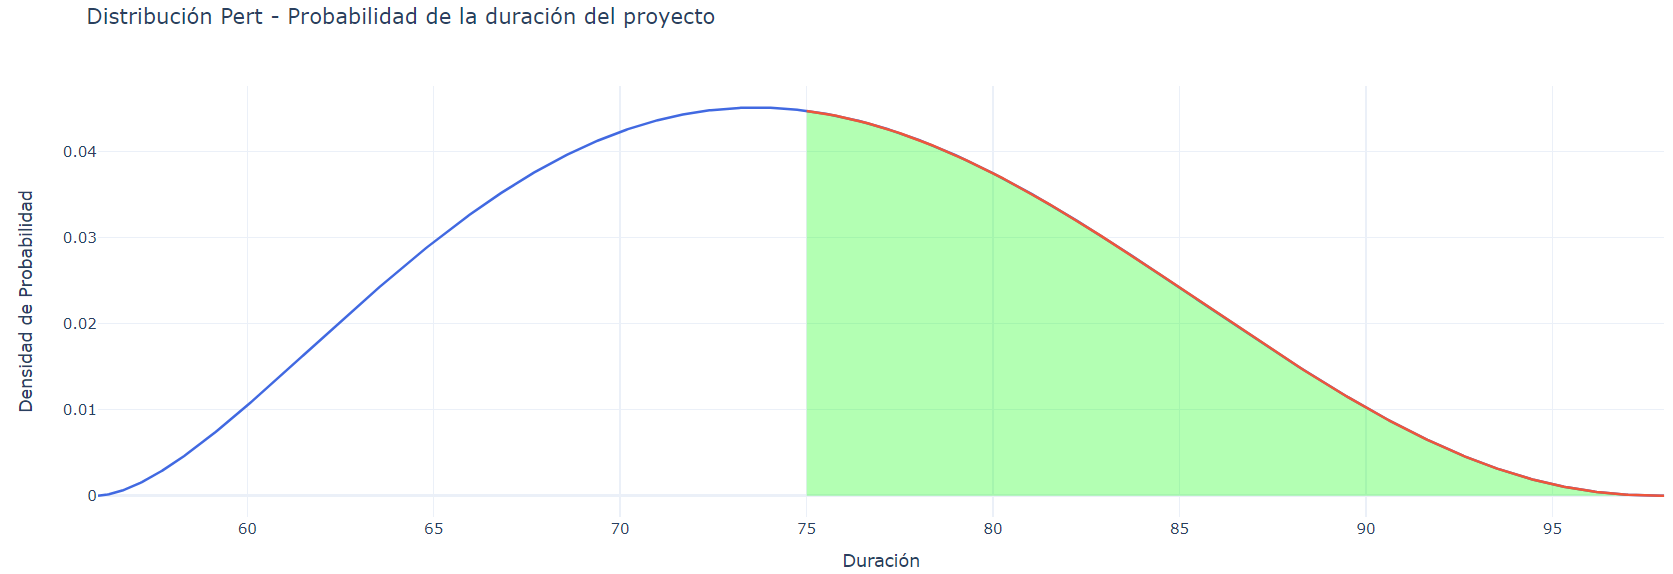

A continuación se calcula el tiempo medio en que se termina el proyecto,
El resultado debe dar 75 según el EF y LF y, efectivamente se demuestra.<br>

In [31]:
p = Node('proyecto')
dep = []
for i in range(df.shape[0]):
            if(df['PREDECESSORS'][i] == None):
                pass

            else:
                for j in df['PREDECESSORS'][i]:
                    dep.append((df['ID'][i], j))
tasks = []
for i,row in df.iterrows():
       #X = random.triangular(row['OPTIMIST'], row['MOSTLIKELY'], row['PESSIMIST'])
       X = row['AVERAGE']
       tasks.append((row['ID'], {"duration": round(X, 2)}))

    # Cargar al proyecto las tareas y sus duraciones
for t in tasks:
        p.add(Node(t[0], duration=t[1]["duration"]))

    # Cargar al proyecto sus dependencias (secuencias)
for d in dep:
        p.link(d[0],d[1])

    # Actualizar el proyecto:
p.update_all()

avg =p.duration

print(f'Duración promedio del proyecto: {avg} horas')

Duración promedio del proyecto: 75.0 horas


En Resumen, las probabilidades de cumplir con el proyecto en más de 75 horas son:
- Distribución Triángular: **47.67%**
- Distribución PERT: **40.83%**

# <font color="magenta">*4. Cálculos alternativos.*</font>

Otra manera de calcular las probabilidades es asumiendo que la duración de cada tarea sigue una distribución normal.

Este enfoque es más simple y más fácil de entender, pero puede subestimar la probabilidad de eventos extremos y la incertidumbre, ya que la distribución normal no tiene colas pesadas.

### 4.1 Distribución normal

Se utiliza como *media* la duración promedio, en este caso 75 y; se estima la *desviación estándar* utilizando solo las tareas críticas, ya que estas tienen el mayor impacto en la duración total del proyecto.

In [32]:
# Media (75)
mu = 75
# Desviación estándar
sigma_sq = [((row['PESSIMIST'] - row['OPTIMIST']) / 6) ** 2 if row['CRITICAL'] == 'YES' else 0 for index, row in df.iterrows()]
sigma = sum(sigma_sq) ** (0.5)

# Calcular la probabilidad acumulada
probabilidad = norm.cdf(75, loc=mu, scale=sigma)

print(f'La probabilidad de que el proyecto dure más de 75: {round(probabilidad*100,2)}%')

La probabilidad de que el proyecto dure más de 75: 50.0%


### 4.2. Simulación MonteCarlo

Se utilizan los datos generados para determinar la moda.

Todos estos datos son sometidos a una transformación Boxcox para que se ajusten mejor a la distribución Normal y luego realizar las evaluaciones necesarias.

In [33]:
# Datos
dur = np.array(dur)
# Transformación Boxcox
dur , lamb  = boxcox(dur)

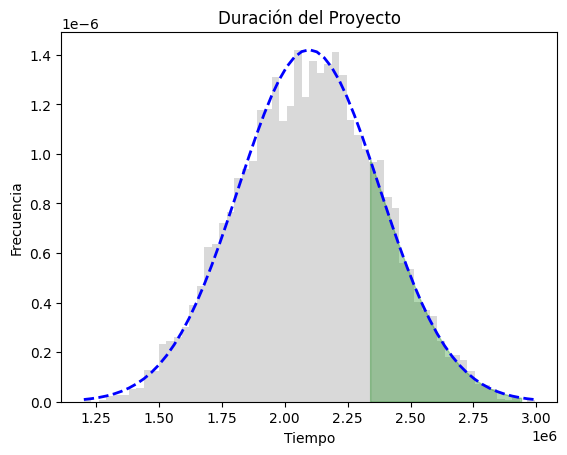

Promedio: 72.81229324950903
Desviación estándar: 42.291613369091436
La probabilidad de que el proyecto dure más de 75.0: 19.38%


In [34]:
# Crear el histograma de los valores de dur
n, bins, patches = plt.hist(dur, bins=60, density=True, color= 'silver', alpha=0.6)

# Ajustar una distribución normal a los datos
mu, std = norm.fit(dur)

# Calcular los valores de la distribución normal ajustada
y = norm.pdf(bins, mu, std)

# Confeccion el histograma y la distribución normal ajustada
plt.plot(bins, y, 'b--', linewidth=2)

# Agregar una sombra debajo de la curva de la distribución normal
value = avg #75
if value != None:
        valamb = boxcox(value,lamb)
        x = np.linspace(valamb, mu + 3 * std, 1000)
        plt.fill_between(x, norm.pdf(x, mu, std), color='green', alpha=0.3)
        prob_tir = 1- norm.cdf(valamb, loc=mu, scale=std)
        p1 = f'La probabilidad de que el proyecto dure más de {round(value,0)}: {round(prob_tir*100,2)}%'
        pass

# Transformación inversa de Box-Cox
mu = inv_boxcox(mu, lamb)
std = inv_boxcox(std, lamb)

# Graficar el histograma y la distribucion normal
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.title('Duración del Proyecto')


plt.show()


print("Promedio:", mu)
print("Desviación estándar:", std)
if value != None: print(p1)

# <font color="magenta">*5. Conclusión.*</font>

Las probabilidades de finalizar el proyecto, en determinado tiempo, cambia dependiendo del criterio y del grado de incertidumbre asociada a la duración de cada tarea.

Los valores obtenidos en algunos casos no son idénticos o cercanos y esto se debe a que las distribuciones tienen diferentes enfoques.

Distribución Triangular y PERT:

- Estas distribuciones son útiles cuando la duración de las tareas no se conoce con certeza y existe una variedad de posibles escenarios. La distribución triangular es una aproximación simple pero efectiva que considera un valor más probable, un valor mínimo y un valor máximo para la duración de una tarea. La distribución PERT (Program Evaluation and Review Technique) es una versión más refinada que agrega la noción de la estimación más probable y utiliza una fórmula para calcular la media basada en estos tres valores.
Son  más flexibles que la distribución normal y pueden capturar mejor la incertidumbre en la duración de las tareas, especialmente si hay eventos extremos poco probables pero posibles.
Se aplica en proyectos nuevos donde, los tiempos se estiman en base a tareas similares.

Distribución Normal:

- Se utiliza cuando las duraciones de las tareas son más estables y, se puede presumir que siguen una distribución normal. Se aplica cuando se analizan métodos y tiempo en el estudio del trabajo.
